In [7]:
import os, sys, logging, yaml, torch, random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

from src.data.trajectory_manager import TrajectoryManager
from src.models.wMLP import weakFormMLP

logging.basicConfig(
    filename='test.log',  
    filemode='w',  
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
)    

config_path = 'config.yaml'
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

model_name = config['model']['name']
checkpoint_path = f'./{model_name}_checkpoint.pt'
# Check if the checkpoint exists, if so, load the metadata and override the yaml config
if os.path.exists(checkpoint_path) and config['training']['load_checkpoint']:
    logging.info(f"Checkpoint found at {checkpoint_path}, overriding the yaml config.")
    checkpoint = torch.load(checkpoint_path)
    metadata = checkpoint['metadata']
else:
    logging.info(f"No checkpoint found at {checkpoint_path}, using the yaml config.")
    metadata = {'config': config}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the TrajectoryManager
tm = TrajectoryManager(metadata, device=device)
_, datasets, data_meta = tm.process_all()
train_set,validation_set,test_set = datasets

# Initialize model and load trained weights
model = weakFormMLP(config['model'], data_meta).to(device)
if config['data']['double_precision']:
    model = model.double()

checkpoint = torch.load('./double_pendulum_wmlp.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # set model to evaluation mode if needed

traj_train = random.choice(train_set)
traj_val = random.choice(validation_set)
traj_test = random.choice(test_set)

/var/folders/by/xztw5fxd6bjf5q4gm75yypj00000gn/T/ipykernel_50992/4279542459.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./double_pendulum_w

RMSE: 0.0012560765


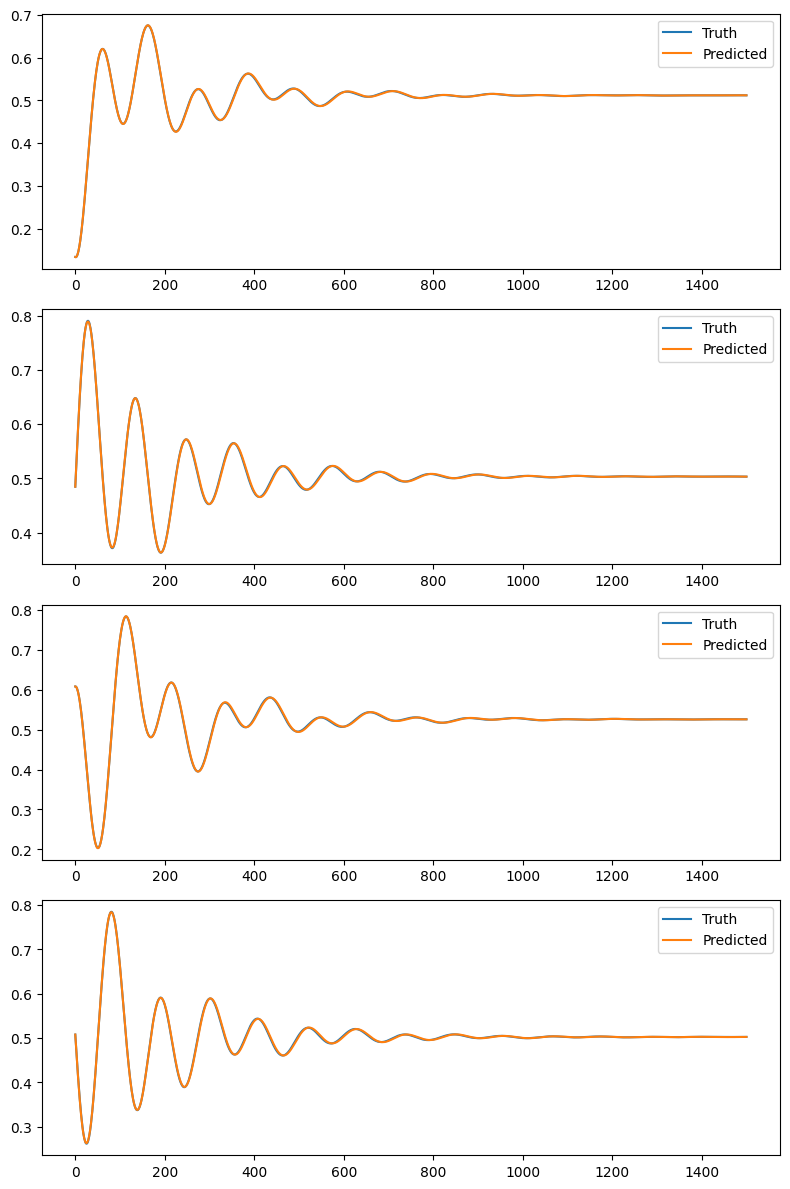

In [8]:
truth = traj_test
x_truth = truth[:, :data_meta['n_state_features']].detach().cpu().numpy()

x0, u0 = truth[0, :data_meta['n_state_features']], truth[0,-data_meta['n_control_features']:]
x_pred = model.predict(x0, u0, ts=tm.t[0]).detach().cpu().numpy()   

# Compute RMSE per dimension between predicted and true states
rmse = np.sqrt(np.mean((x_pred - x_truth)**2))
print("RMSE:", rmse)

# Create 4 subplots, one for each state dimension
fig, axes = plt.subplots(x_truth.shape[-1], 1, figsize=(8, 12))
for i in range(x_truth.shape[-1]):
    axes[i].plot(x_truth[:, i], label='Truth')
    axes[i].plot(x_pred[:, i], label='Predicted')
    axes[i].legend()
    
plt.tight_layout()
plt.show()